/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will 

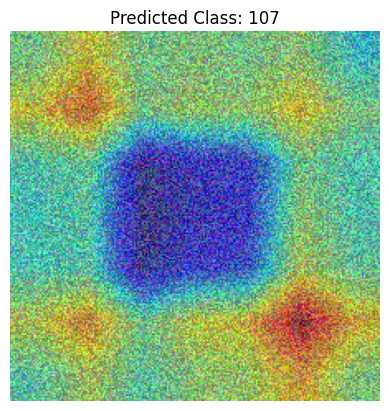

In [ ]:
# Explain a CNN model's predictions using Grad-CAM in PyTorch
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import matplotlib.pyplot as plt

# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.eval()

# Define variables to capture gradients and activations
gradients = None
activations = None

# Define hooks to capture gradients and activations
def save_gradients(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

def save_activations(module, input, output):
    global activations
    activations = output

# Attach hooks to the target layer
target_layer = model.layer4[1].conv2
target_layer.register_backward_hook(save_gradients)
target_layer.register_forward_hook(save_activations)

# Fetch a sample image from torchvision datasets
dataset = datasets.FakeData(transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]))
image, _ = dataset[0]  # Get the first image
image = transforms.ToPILImage()(image)  # Convert to PIL for visualization

# Preprocess the image for the model
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image).unsqueeze(0)

# Perform a forward pass
output = model(input_tensor)
predicted_class = output.argmax(dim=1).item()

# Perform a backward pass for the predicted class
model.zero_grad()
output[0, predicted_class].backward()

# Generate Grad-CAM heatmap
weights = gradients.mean(dim=[2, 3], keepdim=True)
heatmap = (weights * activations).sum(dim=1).squeeze().relu()

# Normalize the heatmap and overlay it on the original image
heatmap = heatmap / heatmap.max()
heatmap = transforms.ToPILImage()(heatmap.cpu())
heatmap = heatmap.resize(image.size, resample=Image.BILINEAR)

# Display the image with the Grad-CAM heatmap
plt.imshow(image)
plt.imshow(heatmap, alpha=0.5, cmap='jet')
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()

In [1]:
## Strong LLM
!pip install flax
!pip install flaxmodels
import jax
import jax.numpy as jnp
import numpy as np
from flax import linen as nn
import flaxmodels
import matplotlib.pyplot as plt
from PIL import Image

# --- Helper: Image Preprocessing ---
def preprocess_image(image):
    """
    Resize image to 224x224, convert to a float32 array in [0,1],
    normalize using ImageNet means and stds, and add a batch dimension.
    (Note: JAX/Flax models typically expect NHWC layout.)
    """
    image = image.resize((224, 224))
    img = np.array(image).astype(np.float32) / 255.0  # shape (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean) / std
    return jnp.expand_dims(img, axis=0)  # shape (1, H, W, C)

# --- Load Pre-trained ResNet-18 in Flax ---
# Here we use flaxmodels which provides pre-trained weights similar to torchvision.
model = flaxmodels.ResNet18(pretrained=True)
# Initialize model parameters using a dummy input.
key = jax.random.PRNGKey(0)
dummy_input = jnp.ones((1, 224, 224, 3), dtype=jnp.float32)
variables = model.init(key, dummy_input)
params = variables['params']

# --- Define Functions for Grad-CAM ---
# For Grad-CAM we want to “split” the network.
# We assume that our model can be decomposed into a feature_extractor and classifier_head.
# (If not, you can modify the model to output the intermediate features you need.)

def feature_extractor(params, x):
    """
    Applies the model up to the target layer. In this example we assume
    that flaxmodels.ResNet18 exposes a method `extract_features` that returns
    the activation maps from the target layer (here analogous to PyTorch’s
    model.layer4[1].conv2).
    """
    # The following call is library‑dependent. In your case, you may need to modify it.
    features = model.extract_features({'params': params}, x)
    return features  # expected shape: (1, H, W, C)

def classifier_head(params, features):
    """
    Applies the rest of the model (global pooling, fully-connected layer, etc.)
    to convert the feature maps into logits.
    """
    logits = model.classify_features({'params': params}, features)
    return logits

# --- Get a Sample Image ---
# In PyTorch the sample came from FakeData. Here we simulate with a random image.
image = Image.fromarray(np.uint8(np.random.rand(224, 224, 3) * 255))

# Preprocess the image
input_tensor = preprocess_image(image)

# --- Forward Pass: Get Prediction ---
# We run the full model to obtain the logits.
logits = model.apply({'params': params}, input_tensor)
predicted_class = int(jnp.argmax(logits, axis=-1)[0])
print("Predicted class:", predicted_class)

# Also run the feature extractor to obtain the target activation maps.
target_activation = feature_extractor(params, input_tensor)  # e.g. shape (1, H, W, C)

# --- Backward Pass: Compute Gradients for Grad-CAM ---
# Define a function that gives the score (logit) for the predicted class,
# given the intermediate activations.
def score_from_activation(act):
    # Pass the feature maps through the classifier head.
    logits = classifier_head(params, act)
    # Return the logit for the previously predicted class.
    return logits[0, predicted_class]

# Compute the gradient of the score with respect to the target activation.
grad_fn = jax.grad(score_from_activation)
gradients = grad_fn(target_activation)  # same shape as target_activation

# --- Compute Grad-CAM Heatmap ---
# In PyTorch the weights are computed as the average over spatial dims (channels in C,H,W).
# Here we assume target_activation is in NHWC so we average over H and W (axes 1 and 2).
weights = jnp.mean(gradients, axis=(1, 2), keepdims=True)  # shape (1, 1, 1, C)

# Compute the weighted combination of the feature maps.
cam = jnp.sum(weights * target_activation, axis=-1)  # shape (1, H, W)
cam = jnp.maximum(cam, 0.0)  # Apply ReLU
cam = cam[0]  # Remove batch dimension
cam = cam / (jnp.max(cam) + 1e-8)  # Normalize between 0 and 1

# --- Convert Heatmap for Visualization ---
cam_np = np.array(cam)  # convert to NumPy array
# Convert the normalized heatmap to an image and resize to the original image size.
heatmap = Image.fromarray(np.uint8(255 * cam_np))
heatmap = heatmap.resize(image.size, resample=Image.BILINEAR)

# --- Display the Image with Grad-CAM Overlay ---
plt.imshow(image)
plt.imshow(heatmap, alpha=0.5, cmap='jet')
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()


ScopeCollectionNotFound: Tried to access "mean" from collection "batch_stats" in "/BatchNorm_0" but the collection is empty. (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.ScopeCollectionNotFound)

In [1]:
## Weak LLM
import jax
import jax.numpy as jnp
import jax.nn as jnn
import flax.linen as nn
import torchvision.transforms as transforms
from flax import serialization
import matplotlib.pyplot as plt
from PIL import Image

class SomeLayer(nn.Module):
    features: int
    key: jax.random.PRNGKey  # Explicitly define the PRNGKey as a parameter to the class

    @nn.compact
    def __call__(self, x):
        # MODIFIED: pass key explicitly to prevent global state mutation
        subkey, self.key = jax.random.split(self.key)  # Split the key for a new operation
        return jnn.relu(nn.Dense(self.features)(x))  # Use a dense layer with relu activation

def generate_random_tensor(shape, dtype=jnp.float32, key=None):  # MODIFIED: Explicit dtype and PRNGKey
    if key is None:
        raise ValueError("PRNG key must be provided")  # Error handling for missing key
    subkey, key = jax.random.split(key)  # Split key for randomness
    return jax.random.normal(subkey, shape, dtype=dtype)  # Generate a tensor with specified dtype

def main():
    key = jax.random.PRNGKey(0)  # Initialize a PRNGKey
    input_tensor_shape = (10, 10)  # Define the shape of the input tensor
    input_tensor = generate_random_tensor(input_tensor_shape, dtype=jnp.float32, key=key)  # MODIFIED: Use the modified function

    layer = SomeLayer(features=5, key=key)  # Pass the PRNGKey explicitly
    output = layer(input_tensor)

    # Assuming we have an image that we want to display and overlay with Grad-CAM heatmap
    image = Image.open('path_to_image.jpg')  # Load an image
    heatmap = transforms.Resize(image.size)(output)  # Resize output to image size (assuming output is suitable for heatmap)

    # Display the image with the Grad-CAM heatmap
    plt.imshow(image)
    plt.imshow(heatmap, alpha=0.5, cmap='jet')
    plt.title("Predicted Class: Example Class")  # Example title
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()

CallCompactUnboundModuleError: Can't call compact methods on unbound modules (https://flax.readthedocs.io/en/latest/api_reference/flax.errors.html#flax.errors.CallCompactUnboundModuleError)

In [ ]:
"""Error Code
layer = SomeLayer(features=5, key=key)  # Pass the PRNGKey explicitly
output = layer(input_tensor)

Error
CallCompactUnboundModuleError: Can't call compact methods on unbound modules

Fix guide
Initialize the module with layer.init() to create its parameters using the input shape and a PRNG key. Then use layer.apply() to process the input tensor with the initialized parameters.

Correct Code
layer = SomeLayer(features=5, key=key)  # Pass the PRNGKey explicitly
params = layer.init(key, input_tensor)  # Initialize the layer with parameters
output = layer.apply(params, input_tensor)
"""

"""Error Code
subkey, self.key = jax.random.split(self.key)

Error
SetAttributeFrozenModuleError: Can't set key=[ 928981903 3453687069] for Module of type SomeLayer: Module instance is frozen outside of setup method.

Fix guide
Use a separate random number generator (RNG) stream via Flax’s make_rng mechanism, which is designed for this purpose.
Pass the RNG key through init and apply using the rngs argument, rather than storing and modifying it as a module attribute.

Correct Code
subkey, self.key = jax.random.split(self.key)  # Split the key for a new operation
return jnn.relu(nn.Dense(self.features)(x))  # Use a dense layer with relu activation
params = layer.init({'params': key, 'rng': key}, input_tensor)
output = layer.apply(params, input_tensor, rngs={'rng': key})
"""

"""Error Code
image = Image.open('path_to_image.jpg')

Error
FileNotFoundError: [Errno 2] No such file or directory: 'path_to_image.jpg'

Fix
By generating a synthetic image in memory

Correct Code
dummy_image_data = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)
image = Image.fromarray(dummy_image_data)
"""

"""Error Code
heatmap = transforms.Resize(image.size)(np.array(output))
Error
TypeError: Unexpected type <class 'jaxlib.xla_extension.ArrayImpl'>
TypeError: Unexpected type <class 'numpy.ndarray'>

Fix
The error TypeError: Unexpected type <class 'jaxlib.xla_extension.ArrayImpl'> occurs because torchvision.transforms. Resize expects a PyTorch tensor, NumPy array, or PIL image as input, but output is a JAX array (jaxlib.xla_extension.ArrayImpl). Therefore, convert the JAX array (output) to a format compatible with torchvision.transforms.Resize, such as a NumPy array, before applying the transformation.

Correct Code
output_np = np.array(output)  # Convert JAX array to NumPy
output_img = Image.fromarray(output_np.astype(np.uint8))  # Convert to PIL Image
heatmap = transforms.Resize(image.size)(output_img)

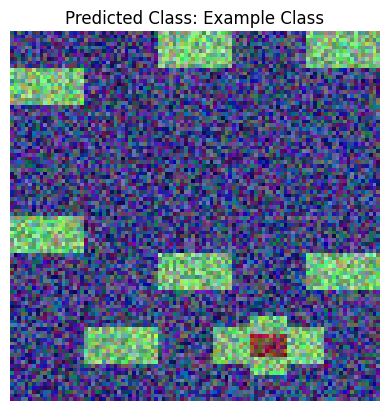

In [13]:
## Fixed Code
## Weak LLM
import jax
import jax.numpy as jnp
import jax.nn as jnn
import flax.linen as nn
import numpy as np
import torchvision.transforms as transforms
from flax import serialization
import matplotlib.pyplot as plt
from PIL import Image

class SomeLayer(nn.Module):
    features: int
    key: jax.random.PRNGKey
    @nn.compact
    def __call__(self, x):
        # MODIFIED: pass key explicitly to prevent global state mutation
        # subkey, self.key = jax.random.split(self.key)  # Split the key for a new operation
        subkey = self.make_rng('rng')
        return jnn.relu(nn.Dense(self.features)(x))  # Use a dense layer with relu activation

def generate_random_tensor(shape, dtype=jnp.float32, key=None):  # MODIFIED: Explicit dtype and PRNGKey
    if key is None:
        raise ValueError("PRNG key must be provided")  # Error handling for missing key
    subkey, key = jax.random.split(key)  # Split key for randomness
    return jax.random.normal(subkey, shape, dtype=dtype)  # Generate a tensor with specified dtype

def main():
    key = jax.random.PRNGKey(0)  # Initialize a PRNGKey
    input_tensor_shape = (10, 10)  # Define the shape of the input tensor
    input_tensor = generate_random_tensor(input_tensor_shape, dtype=jnp.float32, key=key)  # MODIFIED: Use the modified function

    layer = SomeLayer(features=5, key=key)  # Pass the PRNGKey explicitly
    # output = layer(input_tensor)
    params = layer.init({'params': key, 'rng': key}, input_tensor)
    output = layer.apply(params, input_tensor, rngs={'rng': key})

    # Assuming we have an image that we want to display and overlay with Grad-CAM heatmap
    dummy_image_data = np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8)
    image = Image.fromarray(dummy_image_data)
    # heatmap = transforms.Resize(image.size)(np.array(output))  # Convert JAX array to NumPy array
    output_np = np.array(output)  # Convert JAX array to NumPy
    output_img = Image.fromarray(output_np.astype(np.uint8))  # Convert to PIL Image
    heatmap = transforms.Resize(image.size)(output_img)
    # Display the image with the Grad-CAM heatmap
    plt.imshow(image)
    plt.imshow(heatmap, alpha=0.5, cmap='jet')
    plt.title("Predicted Class: Example Class")  # Example title
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()